In [1]:
# Reading Libraries 
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import pickle
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [2]:
# Function to warp the image 

def warp_image(im):

    im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

    pixel_colours = im.reshape((im.shape[0]*im.shape[1], 3))
    norm = colors.Normalize(vmin=-1.0,vmax=1.0)
    norm.autoscale(pixel_colours)
    pixel_colours = norm(pixel_colours).tolist()

    # visualise the colours in a RGB colour space
    H, S, V = cv2.split(im_hsv)

    # define lower and upper ranges of HSV to extract blue board 
    lower_hsv = (75,100,10)
    upper_hsv = (105,255,220)

    # Create mask of pixel inside range of lower and upper colours
    mask = cv2.inRange(im_hsv, lower_hsv, upper_hsv) # (Image, lower_bound, upper_bound)

    # Apply mask to visualise
    im_thresh = im.copy()
    im_thresh[(mask==0),:] = (0,0,0)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    im_contours = im.copy()
    cv2.drawContours(im_contours, contours, -1, (0,255,0), 3) # draw using bright green

    arclength = cv2.arcLength(largest_contour, True)
    epsilon = 0.1 * arclength 
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    corners = corners.reshape(-1, 2)

    # Order the corners
    ordered_corners = np.zeros((4, 2), dtype="float32")
    corners_sum = corners.sum(axis=1)
    corners_diff = np.diff(corners, axis=1)

    ordered_corners[0] = corners[np.argmin(corners_sum)]      
    ordered_corners[2] = corners[np.argmax(corners_sum)]      
    ordered_corners[1] = corners[np.argmin(corners_diff)]    
    ordered_corners[3] = corners[np.argmax(corners_diff)]    

  
    h = 300
    w = 400

    corner_points_output = np.float32([
        [0, 0],
        [w - 1, 0],
        [w - 1, h - 1],
        [0, h - 1]
    ])

    M = cv2.getPerspectiveTransform(np.float32(ordered_corners), corner_points_output)
    warped_image = cv2.warpPerspective(im, M, (w,h))


    return ordered_corners, warped_image

In [3]:
# Function to determine image state 

def find_game_state(warped_image): 

    warped_hsv = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HSV)

    H1, S1, V1 = cv2.split(warped_hsv)

    pixel_colours = warped_image.reshape((warped_image.shape[0]*warped_image.shape[1], 3))
    norm = colors.Normalize(vmin=-1.0,vmax=1.0)
    norm.autoscale(pixel_colours)
    pixel_colours = norm(pixel_colours).tolist()

    # fig = plt.figure()
    # axis = fig.add_subplot(1, 1, 1, projection="3d")
    # axis.scatter(H1.flatten(), S1.flatten(), V1.flatten(), facecolors=pixel_colours, marker='.')
    # axis.set_xlabel("Hue")
    # axis.set_ylabel("Saturation")
    # axis.set_zlabel("Value")
    # axis.view_init(10,90) # (elevation, azimuth, roll): try adjusting to view from different perspectives

    # plt.tight_layout()

    # Red mask
    lower1_red = (175,0,0)
    upper1_red = (200,255,255)

    lower2_red = (0,150,0)
    upper2_red = (10,255,255)

    mask1 = cv2.inRange(warped_hsv, lower1_red, upper1_red)
    mask2 = cv2.inRange(warped_hsv, lower2_red, upper2_red)

    red_mask = cv2.bitwise_or(mask1, mask2)


    # Yellow mask
    lower_yellow = (25,170,100)
    upper_yellow = (35,255,250)

    yellow_mask = cv2.inRange(warped_hsv, lower_yellow, upper_yellow) # (Image, lower_bound, upper_bound)

    # # Apply mask to visualise
    im_red = warped_image.copy()
    im_red[(red_mask==0),:] = (0,0,0)

    im_yellow = warped_image.copy()
    im_yellow[(yellow_mask==0),:] = (0,0,0)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    red_thresh = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
    red_thresh = cv2.morphologyEx(red_thresh, cv2.MORPH_CLOSE, kernel)

    #Apply contour to find edges of the board 
    red_contours, _ = cv2.findContours(red_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    im_red_contours = warped_image.copy()
    cv2.drawContours(im_red_contours, red_contours, -1, (0,255,0), 3) # draw using bright green

    # plt.subplot(121)
    # plt.imshow(im_red_contours) # show the thresholded image


    yellow_thresh = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel)
    yellow_thresh = cv2.morphologyEx(yellow_thresh, cv2.MORPH_CLOSE, kernel)
    yellow_contours, _ = cv2.findContours(yellow_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    im_yellow_contours = warped_image.copy()
    cv2.drawContours(im_yellow_contours, yellow_contours, -1, (0,255,0), 3) # draw using bright green

    # plt.subplot(122)
    # plt.imshow(im_yellow_contours) # show the thresholded image

    (num_components_red, red_label_img, red_stats, red_centroids) = cv2.connectedComponentsWithStats(red_thresh)

    (num_components_yellow, yellow_label_img, yellow_stats, yellow_centroids) = cv2.connectedComponentsWithStats(yellow_thresh)

    game_state = np.zeros((6, 7))

    row_height = 50 
    col_ranges = [0, 70, 110, 180, 230, 280, 350, 400]

    for i in range(1, num_components_red): 
        cx, cy = red_centroids[i]

        row_num = int(cy // row_height)

        for j in range(len(col_ranges) - 1): 
            if col_ranges[j] <= cx < col_ranges[j+1]:
                col_num = j

        game_state[row_num, col_num] = 2

    for i in range(1, num_components_yellow): 
        cx, cy = yellow_centroids[i]


        row_num = int(cy // row_height)

        for j in range(len(col_ranges) - 1): 
            if col_ranges[j] <= cx < col_ranges[j+1]:
                col_num = j

        game_state[row_num, col_num] = 1


        

    return game_state

In [4]:
# Verification functions 

def find_board_accuracy(validation_data, image_path):

    image = cv2.imread(image_path)
    im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_label = os.path.basename(image_path)
    correct_array = validation_data[image_label]

    total_cells = 6*7

    # Warp image
    corners, warped_image = warp_image(im)

    # Find game state 
    game_state = find_game_state(warped_image)

    num_correct = np.sum(correct_array == game_state)
    board_accuracy = num_correct/total_cells

    return board_accuracy


def find_overall_accuracies(validation_data): 

    counter = 0
    total_images = 15

    all_accuracies = []

    for i in range(1, 16):
        image_path = 'connect_four_images_A1/%03d.jpg'%i

        board_accuracy = find_board_accuracy(validation_data, image_path)

        if board_accuracy == 1: 
            counter += 1
        
        all_accuracies.append(board_accuracy)
    
    overall_accuracy = counter/total_images
    average_accuracy = np.mean(all_accuracies)

    return overall_accuracy, average_accuracy


def find_corner_accuracy(validation_data): 

    corner_accuracies = []

    for i in range(1, 16):
        image_path = 'connect_four_images_A1/%03d.jpg'%i

        image = cv2.imread(image_path)
        im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        corners, _ = warp_image(im)

        # Re-order corners to match corners in pickle data 
        temp = corners[2].copy()
        corners[2] = corners[3]
        corners[3] = temp

        print(corners)

        true_corners = validation_data['%03d.jpg'%i]

        error_norm = np.mean(np.linalg.norm(corners - true_corners, axis=1)/np.linalg.norm(true_corners, axis=1))
        
        accuracy = 1-error_norm



        corner_accuracies.append(accuracy)

    
    average_corner_accuracy = np.mean(corner_accuracies)

    return corner_accuracies, average_corner_accuracy

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


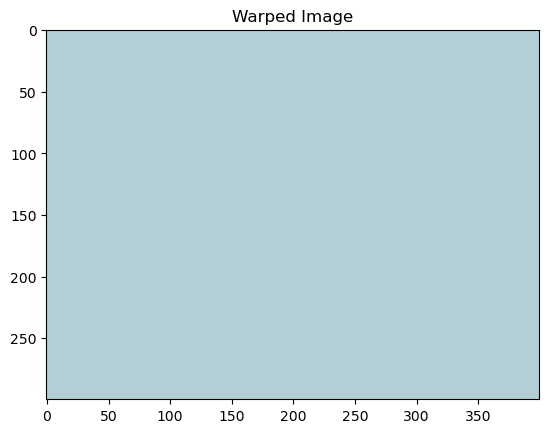

In [5]:
############## MAIN ############################################################

# Read in relevant files 
image_path = 'connect_four_images_A1/011.jpg'
image = cv2.imread(image_path)
im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open('assign1Q2_validationdata/board_states.pkl', 'rb') as f:
        validation_data = pickle.load(f)


# Warp image
corners, warped_image = warp_image(im)
plt.imshow(warped_image)
plt.title("Warped Image")

# Find game state 
game_state = find_game_state(warped_image)
print(game_state)

# Verify the board accuracy 
# board_accuracy = find_board_accuracy(validation_data, image_path)
# print("Board Accuracy:", board_accuracy)





In [6]:

overall_accuracy, average_accuracy = find_overall_accuracies(validation_data)

print("Average accuracy: ", average_accuracy)
print("Overall accuracy: ", overall_accuracy)

Average accuracy:  0.9507936507936509
Overall accuracy:  0.8666666666666667


In [7]:
# Finding accuracy of detected board corners 

with open('assign1Q2_validationdata/board_corners.pkl', 'rb') as f:
        corner_data = pickle.load(f)


# print(corner_data)

corner_accuracies, average_corner_accuracy = find_corner_accuracy(corner_data)

# print(corner_accuracies)
print("Average Corner Accuracy: ", average_corner_accuracy)


[[ 436. 1075.]
 [2135. 1152.]
 [ 653. 2007.]
 [1961. 2167.]]
[[ 352. 1090.]
 [2222. 1007.]
 [ 669. 2083.]
 [2100. 2148.]]
[[ 343.  949.]
 [2305. 1006.]
 [ 444. 2443.]
 [2155. 2302.]]
[[ 446.  995.]
 [2174. 1110.]
 [ 646. 1962.]
 [1968. 2158.]]
[[ 695.  635.]
 [2321.  625.]
 [ 766. 1753.]
 [2166. 1833.]]
[[ 408. 1297.]
 [1756. 1253.]
 [ 524. 2231.]
 [1714. 2144.]]
[[ 379.  875.]
 [2475.  839.]
 [ 576. 2312.]
 [2239. 2139.]]
[[  64.  837.]
 [2502.  828.]
 [ 297. 2442.]
 [2281. 2422.]]
[[ 648.  702.]
 [1976.  693.]
 [ 746. 1647.]
 [1881. 1619.]]
[[ 937. 1919.]
 [2371.  939.]
 [ 937. 1919.]
 [2371.  939.]]
[[ 427.  759.]
 [2123. 1001.]
 [ 427.  759.]
 [1891. 2127.]]
[[ 482. 1050.]
 [2098.  970.]
 [ 619. 2206.]
 [1888. 1931.]]
[[ 617.  682.]
 [2294.  678.]
 [ 746. 2030.]
 [2110. 1799.]]
[[ 291. 1053.]
 [2333. 1023.]
 [ 544. 2189.]
 [2050. 2120.]]
[[ 587. 1013.]
 [2005. 1150.]
 [ 730. 1854.]
 [1861. 2058.]]
Average Corner Accuracy:  0.9668532715057284
